In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [2]:
ddir = '/swot/SUM03/tmp/CESM/'

In [3]:
client = Client('tcp://129.236.21.48:8089')
client

Client Scheduler: tcp://129.236.21.48:8089 Dashboard: http://129.236.21.48:8787/status,Cluster Workers: 16 Cores: 16 Memory: 8.66 TB


In [4]:
ds=xr.open_zarr(ddir+'hybrid_v5_rel04_BC5_ne120_t12_pop62', auto_chunk=False).chunk({'time': 1})
ds

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.

In [5]:
from xbatcher import BatchGenerator

In [6]:
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

In [7]:
def threeD_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

def extract_needed_variables(batch):
    shift_vars = ['SSH','XU','YU']
    coord_vars = ['XU','YU']

    shifts = {'_e': dict(nlon_input=-1),
              '_w': dict(nlon_input=1),
             '_n': dict(nlat_input=-1),
             '_s': dict(nlat_input=1),
             '_ne': dict(nlon_input=-1,nlat_input=-1),
             '_nw': dict(nlon_input=1,nlat_input=-1),
             '_se': dict(nlon_input=-1,nlat_input=1),
             '_sw': dict(nlon_input=1,nlat_input=1),}

    for suf, shift in shifts.items():
        for var in shift_vars:
            batch[var + suf] = batch[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        batch['X'+suf],batch['Y'+suf],batch['Z'+suf], = threeD_coords(batch['XU'+suf],batch['YU'+suf])
    for var in coord_vars:
        for suf in suffixes:
            batch = batch.drop([var+suf])
    return batch

targets=['U','V']
feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']
from sklearn.model_selection import train_test_split

def ds_to_df(batch, w_validation=False, choice='training'):
    #df = batch.reset_index('sample').to_dataframe()
    #X = df.dropna().reset_index(drop=True).loc[:, feature_cols]
    #y = df.dropna().reset_index(drop=True).loc[:, targets]
    df = batch.drop('sample').to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    y = df.loc[:, targets]
    
    if w_validation:
        X,X_t,y,y_t = train_test_split(X,y,test_size=0.2)
        if (choice=='training'):
            return (X,y)
        elif (choice=='validation'):
            return (X_t,y_t)
    else:
        return (X,y)
    

In [31]:
def actual_generator(**kwargs):
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 1200, 'nlat': 1200}, batch_dims={'time': 1},
                    concat_input_dims=True)
    for batch in bg:
        for jt in range(len(batch.sample)):
            bt = batch.isel(sample=jt)
            yield  ds_to_df(extract_needed_variables(bt), kwargs)

In [32]:
import tensorflow as tf
from tensorflow import keras

In [33]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(10, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse','accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 40)                1600      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20)                820       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


In [34]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (14.,5.)



In [35]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Mean Square Error');
        plt.subplot(122)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Model Accuracy');
        plt.show();
        
plot_losses = PlotLosses()

In [36]:
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
#plt.rcParams['figure.figsize'] = (14.,5.)
def plot_history(history):
    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean squared error)')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    plt.subplot(132)
    plt.xlabel('Epoch')
    plt.ylabel(r'Mean Abs Error [$cm/s$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Validation')
    plt.legend()
    plt.subplot(133)
    plt.xlabel('Epoch')
    plt.ylabel(r'Model Accuracy $\%$')
    plt.plot(history.epoch, np.array(history.history['acc']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Validation')
    plt.legend()
    #plt.ylim([0, 5])

In [242]:
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
#plt.rcParams['figure.figsize'] = (14.,5.)
def plot_history(history, xlim):
    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean squared error)')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([20, 350])
    plt.xlim(xlim)
    plt.subplot(132)
    plt.xlabel('Epoch')
    plt.ylabel(r'Mean Abs Error [$cm/s$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Validation')
    plt.legend()
    plt.ylim([3, 13])
    plt.xlim(xlim)

    plt.subplot(133)
    plt.xlabel('Epoch')
    plt.ylabel(r'Model Accuracy [$\%$]')
    plt.plot(history.epoch, np.array(history.history['acc']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Validation')
    plt.legend()
    plt.ylim([0.4, 0.92])
    plt.xlim(xlim)


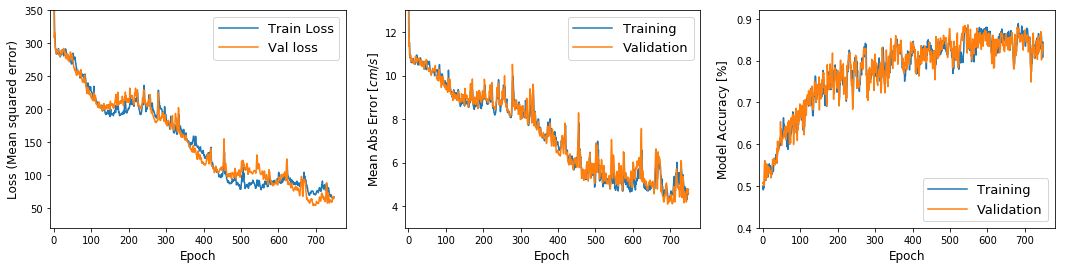

In [243]:
plot_history(model_hist, xlim=[-10,780])
plt.savefig('Figs_regression/NN3layer_train_globe_1200batch_1dperepoch.pdf')

In [29]:
3600*2400/(300*300)

96.0

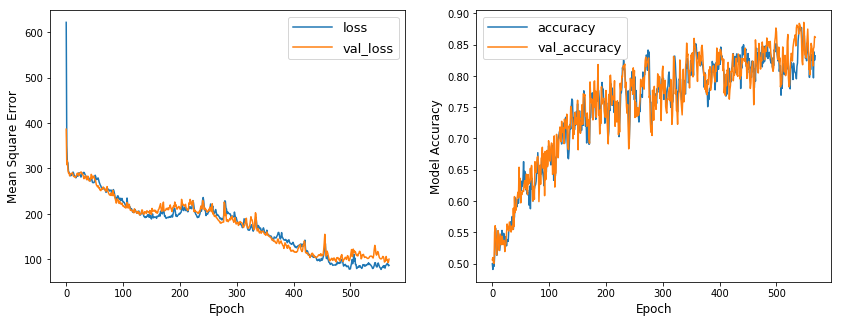

6/6 [==============================] - 52s 9s/step - loss: 105.0048 - mean_absolute_error: 5.8009 - mean_squared_error: 105.0048 - acc: 0.8158 - val_loss: 100.3656 - val_mean_absolute_error: 5.6418 - val_mean_squared_error: 100.3656 - val_acc: 0.8619
Epoch 570/750
3/6 [==============>...............] - ETA: 2s - loss: 86.7045 - mean_absolute_error: 5.5777 - mean_squared_error: 86.7045 - acc: 0.8337

In [ ]:
model_hist = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=6, validation_steps=6, epochs=750, callbacks=[plot_losses])#, use_multiprocessing=True, workers=10)


In [40]:
model_hist.history.keys

<function dict.keys>

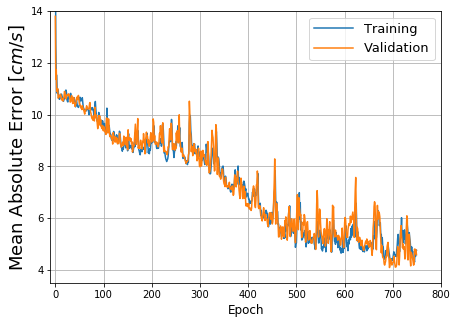

In [247]:
plt.figure(figsize=(7,5))
plt.plot(model_hist.epoch, np.array(model_hist.history['mean_absolute_error']), label='Training')
plt.plot(model_hist.epoch, np.array(model_hist.history['val_mean_absolute_error']), label='Validation')
plt.xlabel('Epoch')
plt.ylabel(r'Mean Absolute Error [$cm/s$]', fontsize=18)
plt.legend()
plt.xlim([-10,800])
plt.ylim([3.5,14])
plt.grid()

plt.savefig('Figs_regression/NN3layer_MAE_train_globe_1200batch_1dperepoch.pdf')

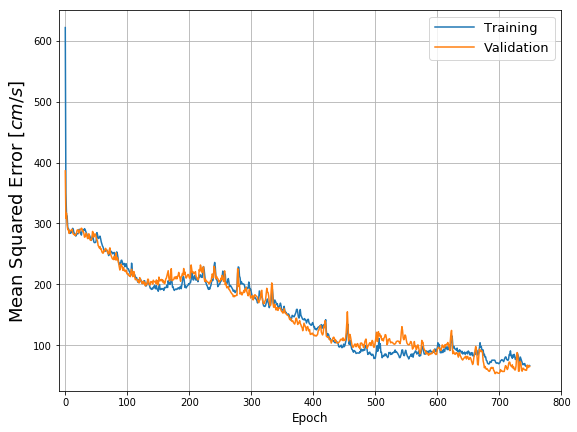

In [51]:
plt.figure(figsize=(9,7))
plt.plot(model_hist.epoch, np.array(model_hist.history['loss']), label='Training')
plt.plot(model_hist.epoch, np.array(model_hist.history['val_loss']), label='Validation')
plt.xlabel('Epoch')
plt.ylabel(r'Mean Squared Error [$cm/s$]', fontsize=18)
plt.legend()
plt.xlim([-10,800])
#plt.ylim([4,14])
plt.grid()

In [52]:
model.save_weights('./model_checkpoints/weights_batch1200_3layer_402010_750d')
model.save('./model_checkpoints/model_batch1200_3layer_402010_750d')

In [54]:
import pickle

In [55]:
with open('./model_checkpoints/History_batch1200_3layer_402010_750d', 'wb') as file_pi:
        pickle.dump(model_hist.history, file_pi)


In [106]:
def ds_to_df_test(batch):
    #df = batch.reset_index('sample').to_dataframe()
    #X = df.dropna().reset_index(drop=True).loc[:, feature_cols]
    #y = df.dropna().reset_index(drop=True).loc[:, targets]
    df = batch.drop('sample').to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    
    return X

def test_generator():
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU']
    bg = BatchGenerator(ds_test.reset_coords()[vars_wanted],
                    input_dims={'nlon': 1200, 'nlat': 1200}, batch_dims={'time': 1},
                    concat_input_dims=True)
    for batch in bg:
        for jt in range(len(batch.sample)):
            bt = batch.isel(sample=jt)
            yield  ds_to_df_test(extract_needed_variables(bt))
            
def eval_generator():
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds_test.reset_coords()[vars_wanted],
                    input_dims={'nlon': 1200, 'nlat': 1200}, batch_dims={'time': 1},
                    concat_input_dims=True)
    for batch in bg:
        for jt in range(len(batch.sample)):
            bt = batch.isel(sample=jt)
            yield  ds_to_df(extract_needed_variables(bt))


In [108]:
ds_test = ds.isel(time=slice(2000,2500))

In [115]:
ds_test_snap = ds_test.isel(time=0)
ds_test_snap

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.array<shape=(

In [121]:
ds_snap0 = ds_test_snap.reset_coords()
ds_snap0

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1500.0 ... 562499.06 587499.06
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 ... 549999.06 574999.06
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 ... 574999.06 599999.06
  * z_w_top             (z_w_top) float32 0.0 1000.0 ... 549999.06 574999.06
Dimensions without coordinates: nlat, nlon
Data variables:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT         

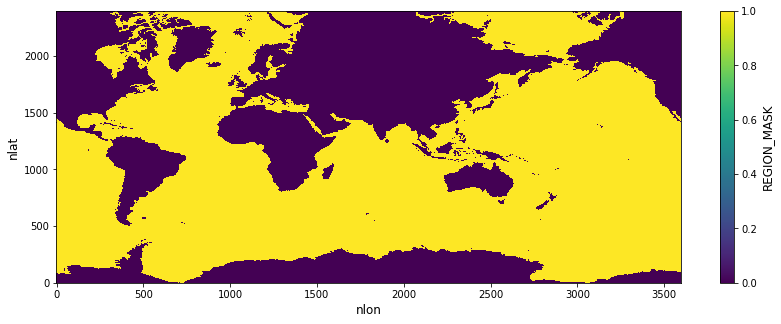

In [122]:
wet_mask = ds_snap0.REGION_MASK>0
wet_mask.plot()


In [123]:
from skimage.morphology import dilation
dry_mask = ~wet_mask.data
dry_mask_dilated2 = dilation(dilation(dry_mask))
wet_mask_dilated = ~dry_mask_dilated2

ds_snap0['wet_mask_dilated'] = xr.DataArray(wet_mask_dilated,
                                    dims=wet_mask.dims, coords=wet_mask.coords)


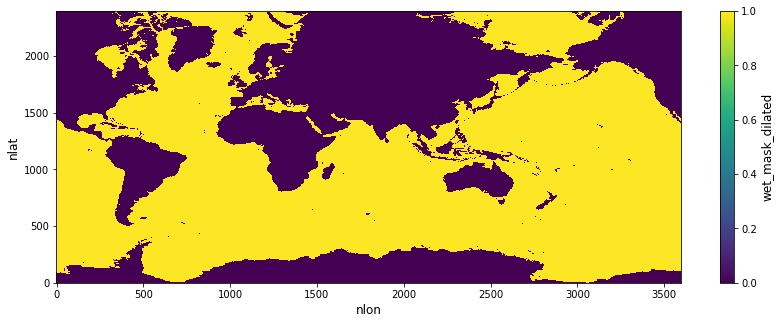

In [124]:
ds_snap0['wet_mask_dilated'].plot()

In [125]:
vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V', 'wet_mask_dilated']
ds_snap1 = ds_snap0[vars_wanted]
ds_snap1

<xarray.Dataset>
Dimensions:           (nlat: 2400, nlon: 3600)
Dimensions without coordinates: nlat, nlon
Data variables:
    SST               (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    SSH               (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    TAUX              (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    TAUY              (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    XU                (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    YU                (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    U                 (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    V                 (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    wet_mask_dilated  (nlat, nlon) bool False False False ... False False False
Attributes:
 

In [133]:
def extract_vars_for_test(ds):
    shift_vars = ['SSH','XU','YU']
    coord_vars = ['XU','YU']

    shifts = {'_e': dict(nlon=-1),
              '_w': dict(nlon=1),
             '_n': dict(nlat=-1),
             '_s': dict(nlat=1),
             '_ne': dict(nlon=-1,nlat=-1),
             '_nw': dict(nlon=1,nlat=-1),
             '_se': dict(nlon=-1,nlat=1),
             '_sw': dict(nlon=1,nlat=1),}

    for suf, shift in shifts.items():
        for var in shift_vars:
            ds[var + suf] = ds[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        ds['X'+suf],ds['Y'+suf],ds['Z'+suf], = threeD_coords(ds['XU'+suf],ds['YU'+suf])
    for var in coord_vars:
        for suf in suffixes:
            ds = ds.drop([var+suf])
    return ds

def ds_to_eval_df(ds):
    targets=['U','V']
    feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']


    df = ds.to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    y = df.loc[:, targets]
    

    return (X,y)

def ds_to_test_df(ds):
    feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']


    df = ds.to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    

    return X
    

In [129]:
ds_snap2 = extract_vars_for_test(ds_snap1)

In [193]:
ds_snap2

<xarray.Dataset>
Dimensions:           (nlat: 2400, nlon: 3600)
Dimensions without coordinates: nlat, nlon
Data variables:
    SST               (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    SSH               (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    TAUX              (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    TAUY              (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    U                 (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    V                 (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    wet_mask_dilated  (nlat, nlon) bool False False False ... False False False
    SSH_e             (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    SSH_w             (nlat, nlon) float32 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    SSH_n    

In [196]:
df = ds_snap2.to_dataframe()
df_masked = df[df.wet_mask_dilated]


In [197]:
df_2 = df_masked.dropna().reset_index(drop=True)

In [209]:
df_x = df.dropna().reset_index(drop=True)

In [210]:
len(df_x)

5324509

In [211]:
df_x2 = df.dropna()

In [212]:
len(df_x2)

5324509

In [208]:
len(df)

8640000

In [207]:
len(df_masked)

5281000

In [199]:
len(df_2)

5276773

In [200]:
X = df_2.loc[:, feature_cols]
y = df_2.loc[:, targets]

In [201]:
print(len(X), len(y))

5276773 5276773


In [202]:
%time model_eval3 = model.evaluate(X,y)
model_eval3

5276773/5276773 [==============================] - 170s 32us/step
CPU times: user 3min 49s, sys: 45.9 s, total: 4min 35s
Wall time: 2min 52s


[70.79165400217138, 4.720551952669866, 70.79165400217138, 0.8345045352528904]

In [203]:
%time pred3 = model.predict(X)
pred3.shape


CPU times: user 2min 25s, sys: 34.8 s, total: 3min
Wall time: 1min 51s


(5276773, 2)

In [204]:
mask3 = ds_snap2.wet_mask_dilated.values

In [206]:
mask3.sum()

5281000

In [134]:
X,y = ds_to_eval_df(ds_snap2)
len(X)

5324509

In [137]:
X.head()

,X,Y,Z,X_e,X_w,X_n,X_s,X_ne,X_se,X_nw,...,SST,SSH,SSH_e,SSH_w,SSH_n,SSH_s,SSH_ne,SSH_se,SSH_nw,SSH_sw
0,-0.979161,-0.056658,0.195020,-0.979161,-0.979161,-0.979011,-0.979311,-0.979011,-0.979311,-0.979011,...,-1.804188,-144.925354,-144.932663,-144.877014,-144.834396,-144.882935,-144.859924,-144.933746,-144.840347,-144.909180
1,-0.979161,-0.056999,0.194920,-0.979161,-0.979161,-0.979011,-0.979311,-0.979011,-0.979311,-0.979011,...,-1.803956,-144.932663,-144.978760,-144.925354,-144.859924,-144.933746,-144.863892,-144.955444,-144.834396,-144.882935
2,-0.979161,-0.057339,0.194821,-0.979161,-0.979161,-0.979011,-0.979311,-0.979011,-0.979311,-0.979011,...,-1.803875,-144.978760,-145.025009,-144.932663,-144.863892,-144.955444,-144.900772,-144.970276,-144.859924,-144.933746
3,-0.979011,-0.056860,0.195713,-0.979011,-0.979011,-0.978861,-0.979161,-0.978861,-0.979161,-0.978861,...,-1.806345,-144.834396,-144.859924,-144.840347,-144.834564,-144.925354,-144.801758,-144.932663,-144.835770,-144.877014
4,-0.979011,-0.057201,0.195614,-0.979011,-0.979011,-0.978861,-0.979161,-0.978861,-0.979161,-0.978861,...,-1.805808,-144.859924,-144.863892,-144.834396,-144.801758,-144.932663,-144.776337,-144.978760,-144.834564,-144.925354


In [139]:
len(y)

5324509

In [138]:
%time model_eval2 = model.evaluate(X,y)
model_eval2


5324509/5324509 [==============================] - 170s 32us/step
CPU times: user 3min 50s, sys: 45.6 s, total: 4min 36s
Wall time: 2min 51s


[70.62113177672919, 4.714874207280783, 70.62113177672919, 0.8334387264628644]

In [140]:
%time pred2 = model.predict(ds_to_test_df(ds_snap2))


CPU times: user 2min 33s, sys: 42.7 s, total: 3min 16s
Wall time: 2min 45s


In [213]:
pred2.shape

(5324509, 2)

Text(0.5,1,'MAE=4.9281874 ')

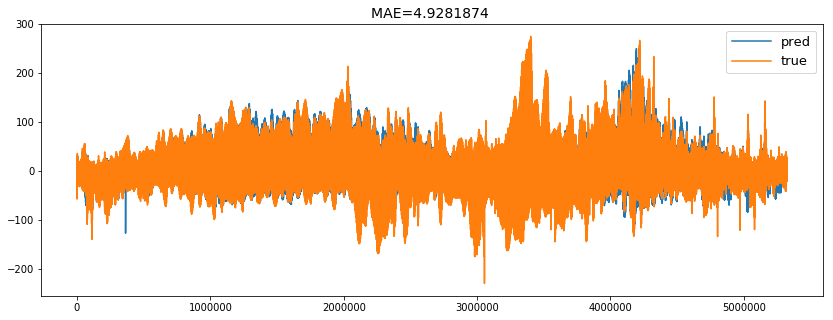

In [146]:
plt.plot(pred2[:,0], label='pred')
plt.plot(y['U'], label='true')
plt.legend()
plt.title('MAE=%s ' %mean_absolute_error(pred2[:,0],y['U']))

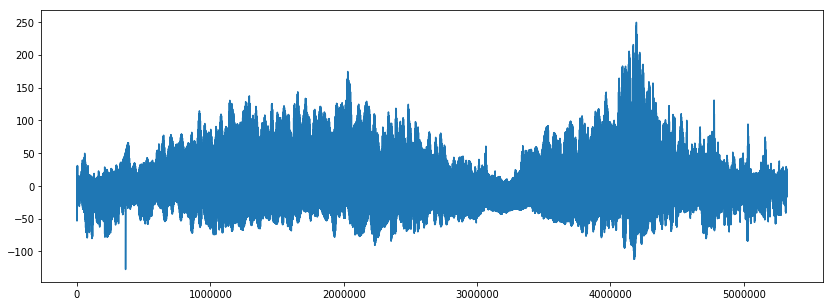

In [147]:
plt.plot(pred2[:,0], label='pred')


Text(0.5,1,'MAE=4.5015626 ')

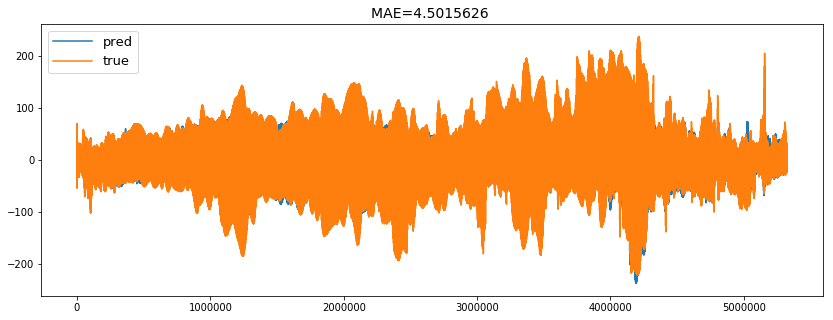

In [144]:
plt.plot(pred2[:,1], label='pred')
plt.plot(y['V'], label='true')
plt.legend()
plt.title('MAE=%s ' %mean_absolute_error(pred2[:,1],y['V']))

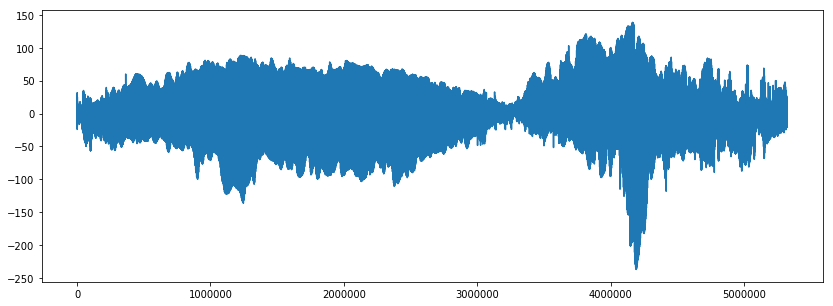

In [145]:
plt.plot(pred2[:,1], label='pred')


In [174]:
uval = ds_snap2.U.values

In [183]:
mask2 = ~np.isnan(ds_snap2.U)

In [214]:
mask_c = ~np.isnan(ds_snap2.SSH.values)
mask_n = ~np.isnan(ds_snap2.SSH_n.values)
mask_s = ~np.isnan(ds_snap2.SSH_s.values)
mask_e = ~np.isnan(ds_snap2.SSH_e.values)
mask_w = ~np.isnan(ds_snap2.SSH_w.values)
mask_ne = ~np.isnan(ds_snap2.SSH_ne.values)
mask_nw = ~np.isnan(ds_snap2.SSH_nw.values)
mask_se = ~np.isnan(ds_snap2.SSH_se.values)
mask_sw = ~np.isnan(ds_snap2.SSH_sw.values)

print(mask_c.sum(),mask_n.sum(),mask_s.sum(),mask_e.sum(),mask_w.sum(),mask_ne.sum(),mask_nw.sum(),mask_se.sum(),mask_sw.sum())


5413142 5413142 5411537 5411790 5411791 5411790 5411791 5410185 5410186


In [220]:
mask_x = ~np.isnan(ds_snap2.X.values)
mask_y = ~np.isnan(ds_snap2.Y.values)
mask_z = ~np.isnan(ds_snap2.Z.values)
print(mask_x.sum(),mask_y.sum(),mask_z.sum())

8640000 8640000 8640000


In [217]:
mask_u = ~np.isnan(ds_snap2.U.values)
mask_v = ~np.isnan(ds_snap2.U.values)
print(mask_u.sum(),mask_v.sum())

5453624 5453624


In [223]:
mask_tot = ~(np.isnan(ds_snap2.SSH.values) | np.isnan(ds_snap2.SSH_e.values)| np.isnan(ds_snap2.SSH_w.values)|np.isnan(ds_snap2.SSH_n.values)|
            np.isnan(ds_snap2.SSH_s.values)|np.isnan(ds_snap2.SSH_ne.values)|np.isnan(ds_snap2.SSH_nw.values)|np.isnan(ds_snap2.SSH_se.values)|
            np.isnan(ds_snap2.SSH_sw.values)
           )

In [224]:
mask_tot.sum()

5324509

In [226]:
u_pred_flat = pred2[:,0]
v_pred_flat = pred2[:,1]

assert mask_tot.sum() == len(u_pred_flat)
assert mask_tot.sum() == len(v_pred_flat)


In [227]:
u_true = ds_snap2.U.values
v_true = ds_snap2.V.values

In [228]:
u_true.shape, v_true.shape

((2400, 3600), (2400, 3600))

In [229]:
u_nn = np.full_like(u_true, np.nan)
u_nn[mask_tot] = u_pred_flat
v_nn = np.full_like(u_true, np.nan)
v_nn[mask_tot] = v_pred_flat


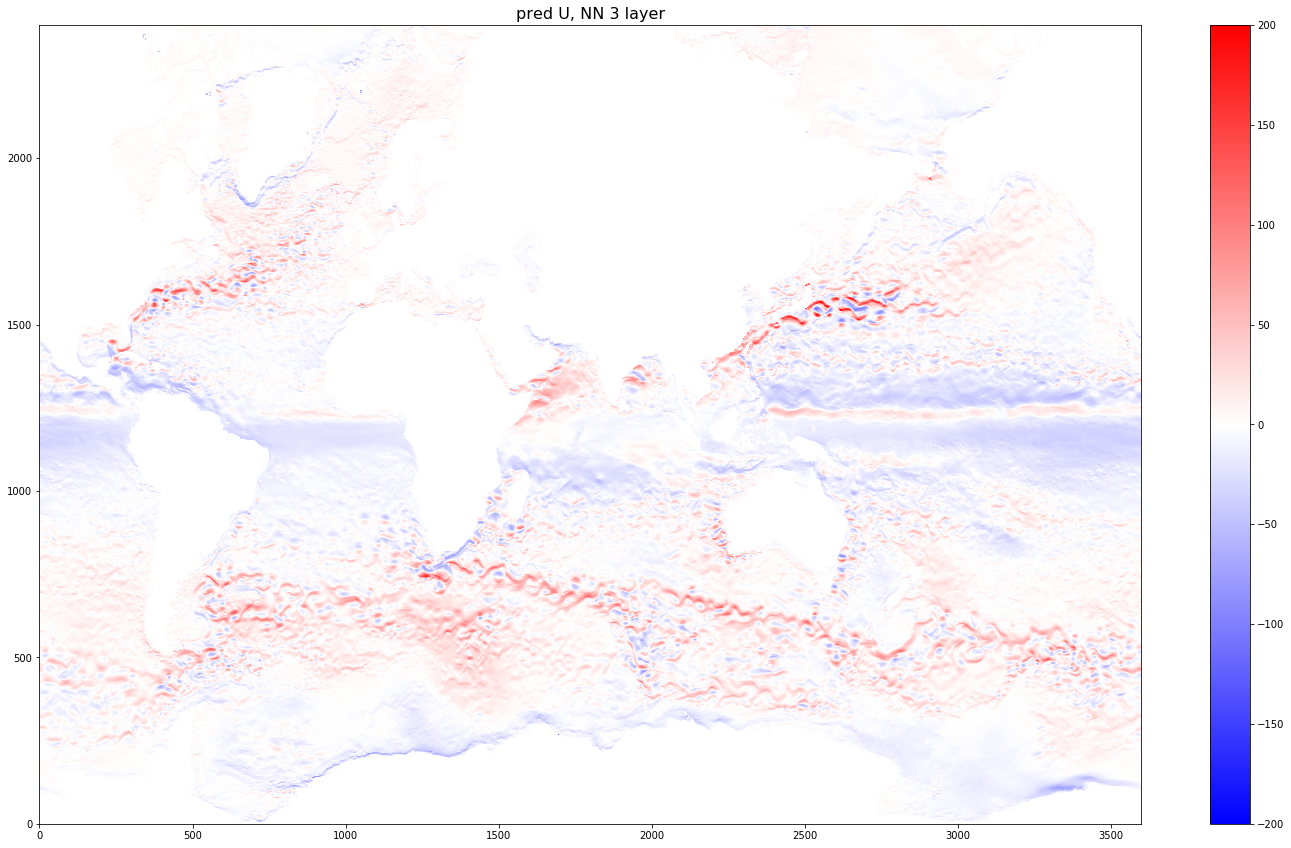

In [231]:
fig = plt.figure(figsize=(20,12))
plt.pcolormesh(u_nn, vmax=200, vmin=-200, cmap='bwr', rasterized=True);
plt.title('pred U, NN 3 layer', fontsize=16)
plt.colorbar()
plt.tight_layout()

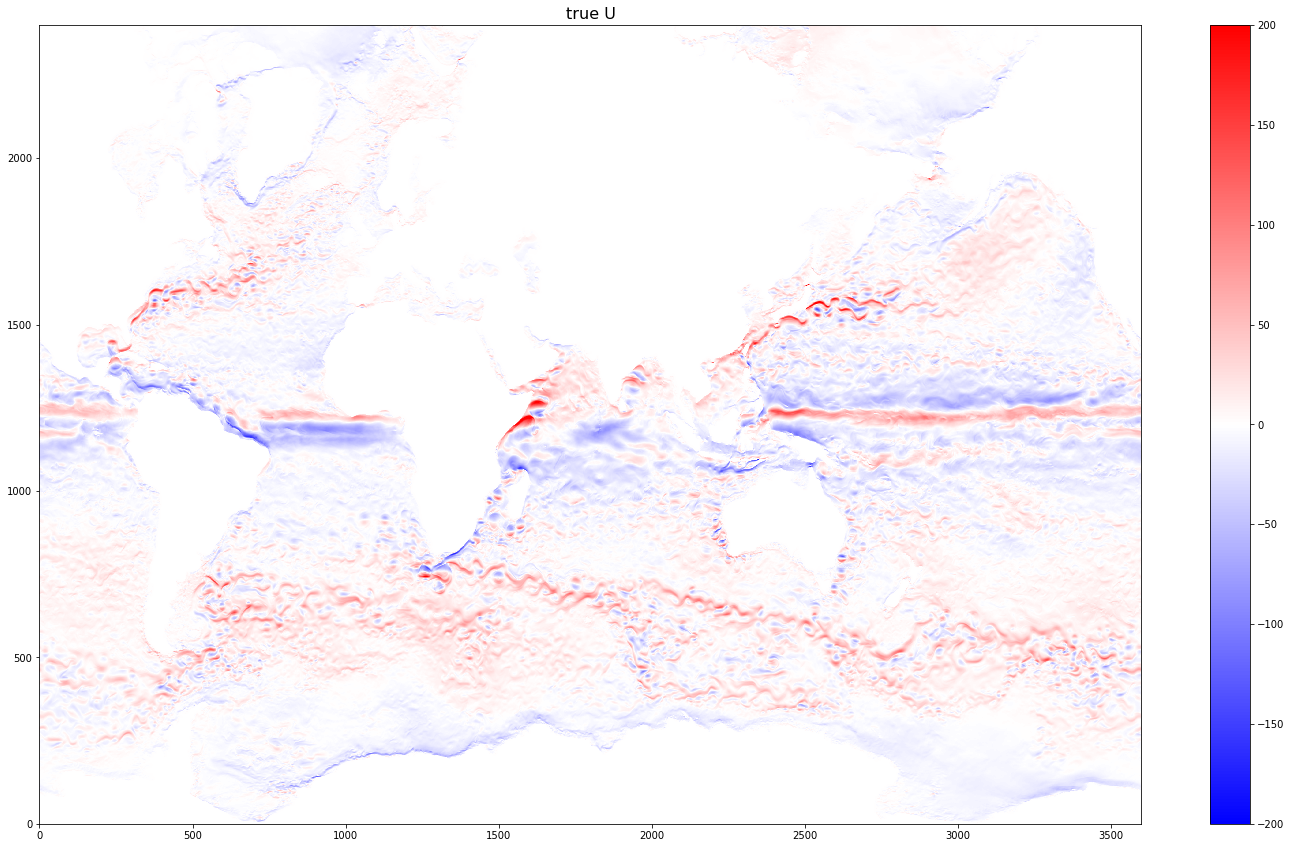

In [232]:
fig = plt.figure(figsize=(20,12))
plt.pcolormesh(u_true, vmax=200, vmin=-200, cmap='bwr', rasterized=True);
plt.title('true U', fontsize=16)
plt.colorbar()
plt.tight_layout()

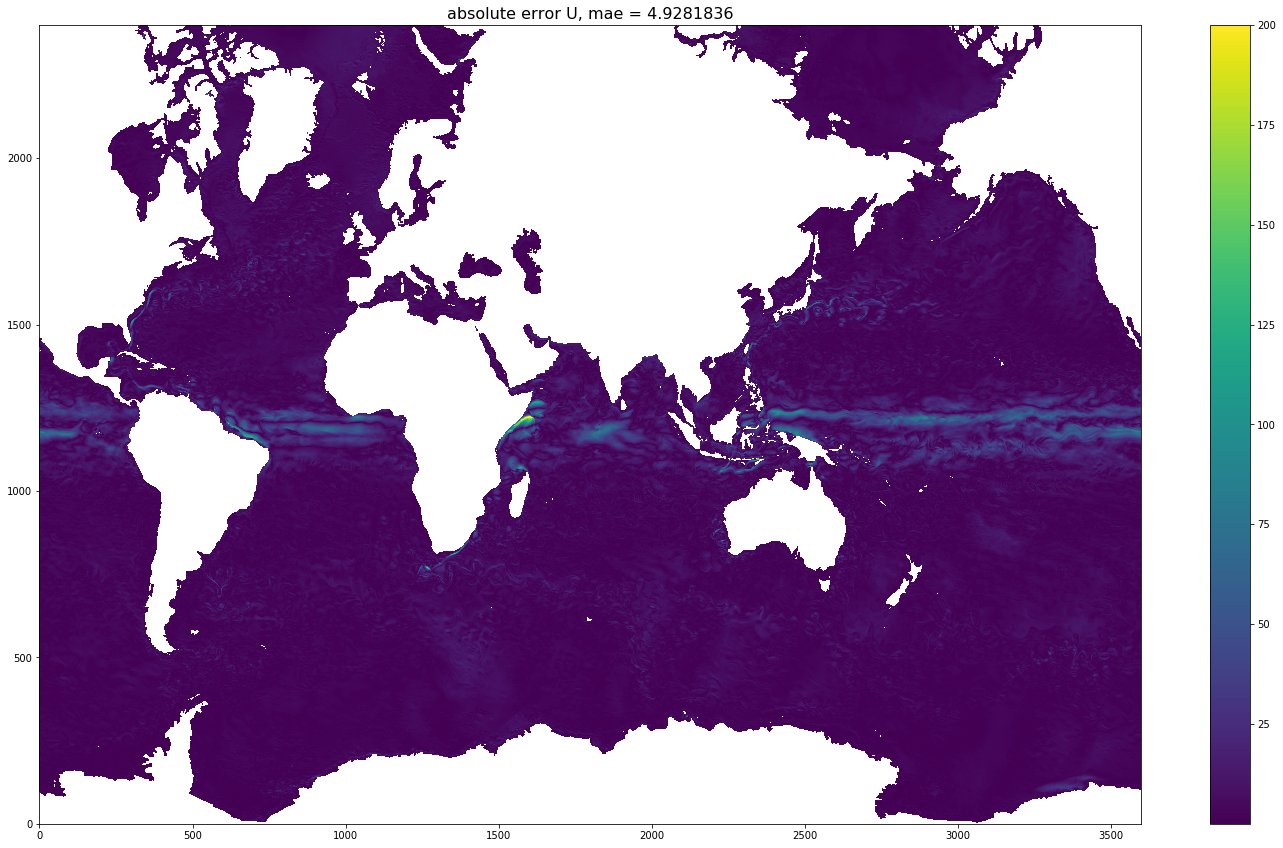

In [237]:
fig = plt.figure(figsize=(20,12))
plt.pcolormesh(np.abs(u_true-u_nn), vmax=200, cmap='viridis', rasterized=True);
plt.title('absolute error U, mae = %s' %(np.nanmean(np.abs(u_true-u_nn))), fontsize=16)
plt.colorbar()
plt.tight_layout()

In [188]:
u_pred_flat = pred2[:,0]
v_pred_flat = pred2[:,1]
mask2 = ~np.isnan(ds_snap2.U.values)

assert mask2.sum() == len(u_pred_flat)
assert mask2.sum() == len(v_pred_flat)


AssertionError: 

In [189]:
mask2.sum()

5453624

In [215]:
len(u_pred_flat)

5324509

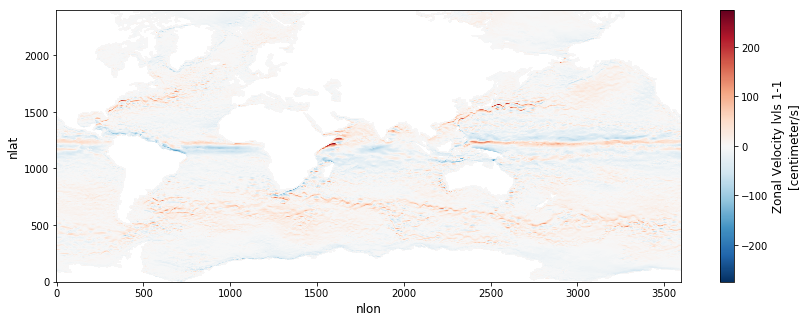

In [152]:
ds_snap2.U.plot()

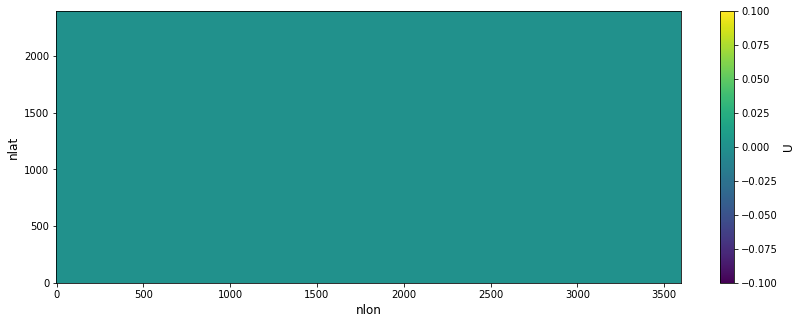

In [169]:
mask1 = (ds_snap2.U==np.NaN)
mask1.plot()

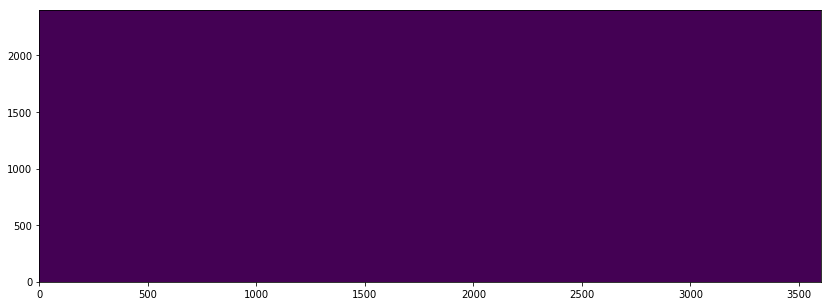

In [171]:
plt.pcolormesh(mask1.values)

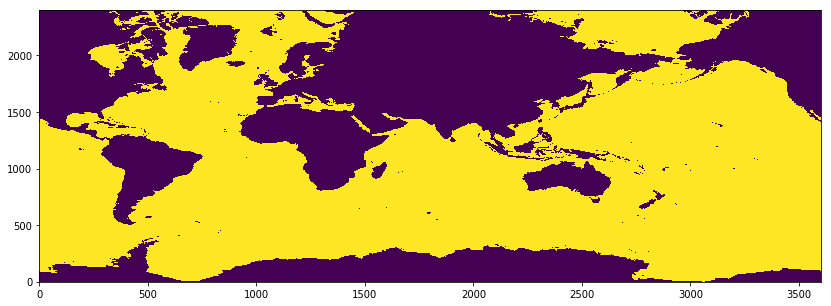

In [164]:
plt.pcolormesh(mask0)

In [149]:
u_pred_flat = pred2[:,0]
v_pred_flat = pred2[:,1]
mask0 = ds_snap2.wet_mask_dilated.values
assert mask0.sum() == len(u_pred_flat)
assert mask0.sum() == len(v_pred_flat)


AssertionError: 

In [192]:
mask0.sum()

5281000

In [135]:
%time model_eval2 = model.evaluate(ds_to_eval_df(ds_snap2))
model_eval2


TypeError: evaluate() missing 1 required positional argument: 'y'

NameError: name 'model_eval2' is not defined

In [110]:
model_eval = model.evaluate_generator(generator=eval_generator(), steps=6)
model_eval


[70.0533106595828, 4.7017875722346005, 70.0533106595828, 0.8335100650724809]

In [111]:
pred0 = model.predict_generator(generator=test_generator(), steps=6)


In [112]:
pred0.shape

(5313889, 2)

In [113]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model


In [114]:
plot_model(model, to_file='Figs_regression/model_plot.png', show_shapes=True, show_layer_names=True)


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.